In [29]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import skimage.transform as tf
import scipy.signal as signal
import re
import sys
def atoi(text):
    return int(text) if text.isdigit() else text.lower()
    
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [4]:
filelist = glob.glob('figs/Z/*.tiff')
filelist.sort(key=natural_keys)
print(filelist)
Z_array = np.array([np.array(cv2.imread(fname, 0)) for fname in filelist])

['figs/Z/Dark_Z.tiff', 'figs/Z/Illumination_Z.tiff', 'figs/Z/ITOfloating.tiff', 'figs/Z/Mofloating_Z.tiff']


In [5]:
filelist = glob.glob('figs/CPD/*.tiff')
filelist.sort(key=natural_keys)
print(filelist)
CPD_array = np.array([np.array(cv2.imread(fname, 0)) for fname in filelist])

['figs/CPD/Dark_CPD.tiff', 'figs/CPD/Illumination_CPD.tiff', 'figs/CPD/ITOfloating_CPD.tiff', 'figs/CPD/Mofloating_CPD.tiff']


In [6]:
transformation = cv2.estimateRigidTransform(Z_array[0], Z_array[2], 0)
transformation
dx = np.zeros_like(transformation)
dx[0,0] = 1
dx[1,1] = 1
dx [0,2] = transformation[0,2]
print("Identified delta x")
dx

Identified delta x


array([[  1.       ,   0.       , -18.9399584],
       [  0.       ,   1.       ,   0.       ]])

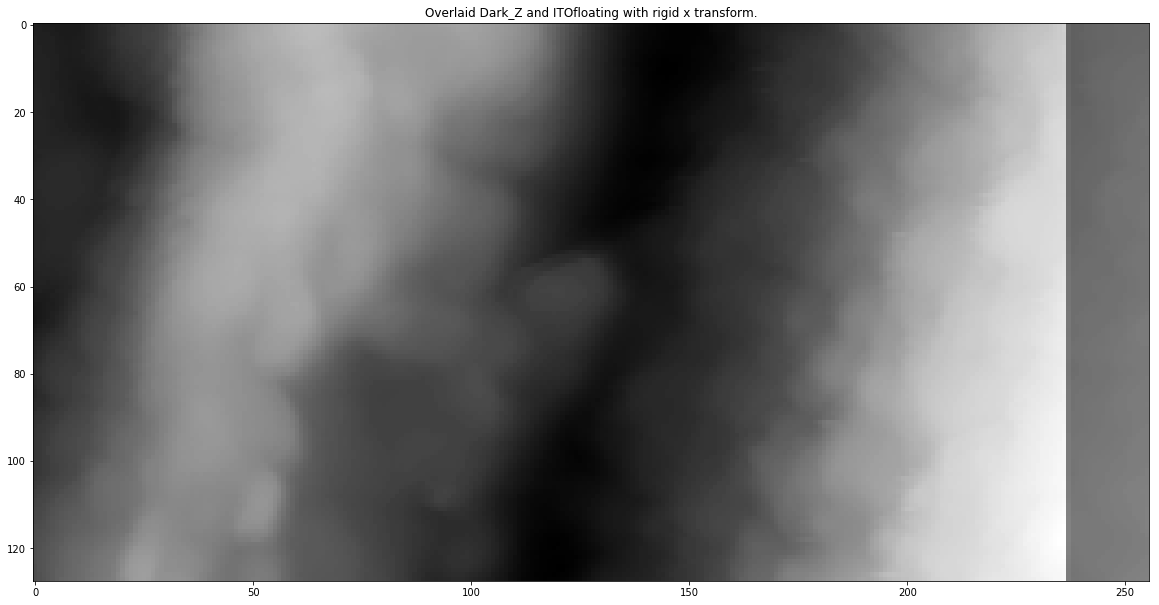

In [36]:
Z_warped = cv2.warpAffine(Z_array[0], dx, Z_array[0].T.shape)
avg = cv2.addWeighted(Z_warped, 0.5, Z_array[2], 0.5,0)
plt.figure(figsize=(20,20))
plt.imshow(avg, cmap="gray")
plt.title("Overlaid Dark_Z and ITOfloating with rigid x transform.")
plt.show()

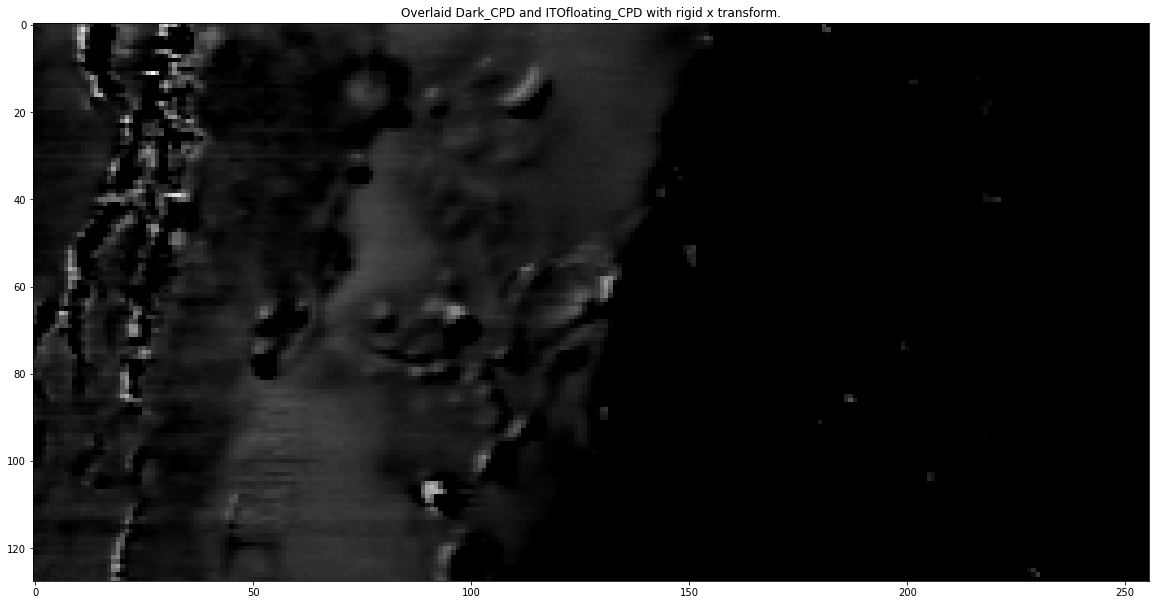

In [35]:
CPD_warped = cv2.warpAffine(CPD_array[0], dx, CPD_array[0].T.shape)
avg = cv2.addWeighted(CPD_warped, 1, CPD_array[2], -1,0)
plt.figure(figsize=(20,20))
plt.imshow(avg, cmap="gray")
plt.title("Overlaid Dark_CPD and ITOfloating_CPD with rigid x transform.")
plt.show()

## Constructing our own code:

In [111]:
def slidingRMSE(src, dst):
    # fix array shapes
    if len(np.asarray(src).shape) == 1:
        src = np.array([src])
    if len(np.asarray(dst).shape) == 1:
        dst = np.array([dst])
        
    # pad array
    width = src.shape[1]
    src_padded = np.pad(src, [(0,0),(width,width)], 'constant', constant_values=0)
    RMSE = []
    for x in range(src_padded.shape[1] - width):
        RMSE.append(np.sqrt(np.mean((src_padded[:,x:x+width]-dst)**2)))
        
    # construct translation matrix
    transform = np.zeros((2,3))
    transform[0,0] = 1
    transform[1,1] = 1
    transform [0,2] = width - np.argmin(RMSE)
    return RMSE, transform

[[1. 0. 0.]
 [0. 1. 0.]]


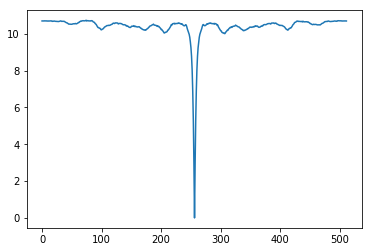

In [99]:
# Sanity check
RMSE, minRMSE = slidingRMSE(Z_array[0], Z_array[0])
plt.plot(RMSE)
print(minRMSE)

[[  1.   0. -19.]
 [  0.   1.   0.]]


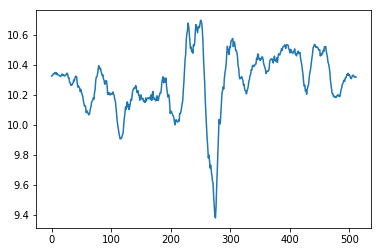

In [100]:
# redo test at top of this notebook, see same result
RMSE, minRMSE = slidingRMSE(Z_array[0], Z_array[2])
plt.plot(RMSE)
print(minRMSE)

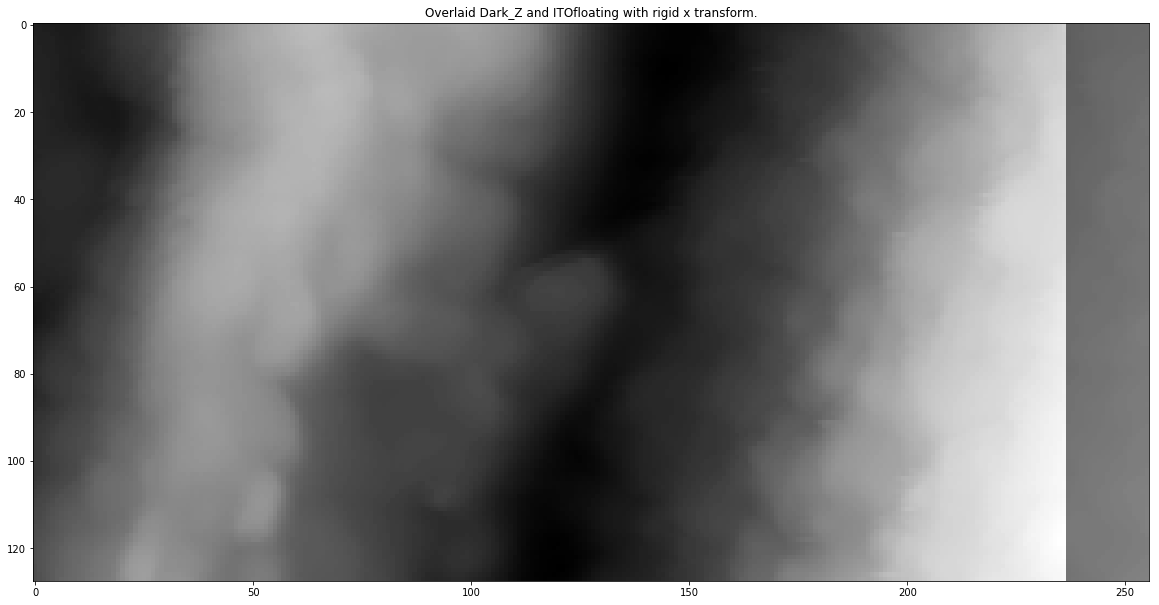

In [103]:
Z_warped = cv2.warpAffine(Z_array[0], minRMSE, Z_array[0].T.shape)
avg = cv2.addWeighted(Z_warped, 0.5, Z_array[2], 0.5,0)
plt.figure(figsize=(20,20))
plt.imshow(avg, cmap="gray")
plt.title("Overlaid Dark_Z and ITOfloating with rigid x transform.")
plt.show()

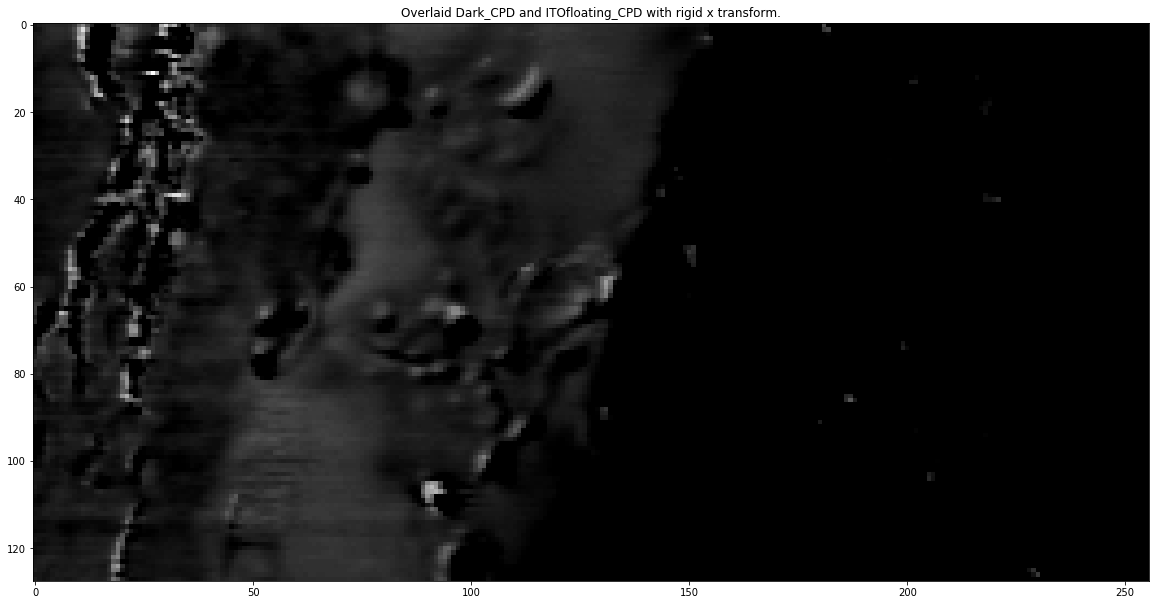

In [104]:
CPD_warped = cv2.warpAffine(CPD_array[0], minRMSE, CPD_array[0].T.shape)
avg = cv2.addWeighted(CPD_warped, 1, CPD_array[2], -1,0)
plt.figure(figsize=(20,20))
plt.imshow(avg, cmap="gray")
plt.title("Overlaid Dark_CPD and ITOfloating_CPD with rigid x transform.")
plt.show()

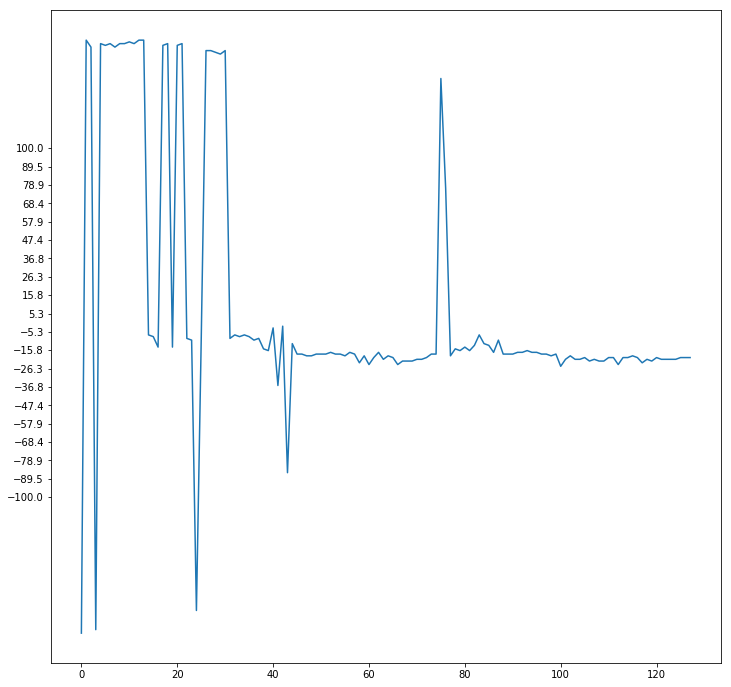

In [120]:
individual_row_transforms = []
for i in range(Z_array[0].shape[0]):
    individual_row_transforms.append(slidingRMSE(Z_array[0][i], Z_array[2][i])[1][0,2])
plt.figure(figsize=(12,12))
plt.yticks(np.linspace(-100,100,20))
plt.plot(individual_row_transforms)